# Trabajo Práctico 1 
### Clasificación sobre datos simulados. 

## Introducción
Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 



In [1]:
# PREAMBULOS
%matplotlib inline

SEED = 1234

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML
from time import time

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)

pd.set_option('precision', 4)

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.svm
from sklearn.tree import DecisionTreeClassifier

import sklearn.model_selection
from scipy.stats import randint as sp_randint

/home/stella/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Carga de datos
X = pd.read_csv("X.csv", index_col="index")
y = pd.read_csv("y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego. 
    
X_competencia = pd.read_csv("X_competencia1.csv", index_col="index")
y_competencia_ejemplo = pd.read_csv("y_competencia_ejemplo.csv", index_col="index")
display(X)
display(y)

# Descomentar si quieren ver los datos para la competencia:
# display(X_competencia) 
# display(y_competencia_ejemplo)

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
0,1.4914,0.1644,1.2315,1.2429,1.5576,0.0455,0.1302,...,-1.1983,-0.0118,1.5375,-0.7727,-0.1401,2.0871,-0.8312
1,-0.2749,0.2780,-1.3108,0.6801,-0.5503,0.6359,-0.4478,...,1.2190,-0.3190,-0.6446,-0.0061,-1.2374,-1.3291,-1.3265
2,-0.2243,-0.5710,-0.2712,-0.1328,-1.0045,0.9315,-1.4507,...,0.9459,0.1430,-0.1989,-0.0393,-0.5866,2.2507,1.4925
3,0.5853,-0.8532,-0.2723,-0.5493,-2.9824,-0.1697,-0.0430,...,1.6488,-0.7363,-0.8866,-1.2717,-0.1493,0.2007,-1.4820
4,-1.4155,1.4187,0.6027,-0.7993,0.2939,-0.1796,-0.7140,...,1.1314,-0.4230,-0.2685,0.3045,-1.2245,-1.9421,1.5186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.2516,0.9375,-1.1980,0.4577,0.9287,0.5373,0.2476,...,0.5829,-0.5494,0.4607,1.2182,0.1025,3.0034,-0.0344
496,0.6246,-1.0590,0.9491,0.2687,0.6610,-1.6657,0.3982,...,-0.1075,0.8993,-0.4229,0.3977,-0.0808,-1.7054,-0.4786
497,0.2677,0.1802,0.7154,0.3542,-0.9023,-1.7792,-0.0121,...,0.8491,0.7469,0.2071,-1.0090,0.3317,-1.7513,-0.5397


,output
index,
0,0
1,0
2,0
3,0
4,1
...,...
495,1
496,0
497,1


In [28]:
X_competencia

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
501,0.2828,2.0610,1.0889,-0.7976,0.6819,-0.0531,0.3860,...,0.6734,0.3584,1.0187,1.4373,-0.7069,0.9051,-0.5420
502,-1.1895,1.1622,0.4257,0.7102,0.2699,1.1044,1.7634,...,-2.1822,0.0875,-0.6501,-1.7537,0.6584,-0.4861,-0.6913
503,-0.2730,-0.2018,0.4408,-1.0598,-0.3892,2.5573,0.1915,...,2.5449,-1.1552,1.0447,-0.6057,-2.2056,-0.4326,-0.2387
504,0.2006,0.5208,0.0377,-0.0886,1.5035,-1.6581,-1.1057,...,-1.7424,-0.5942,0.0929,0.4501,1.7539,-0.3211,2.0208
505,-0.6236,-1.2563,-0.4989,-2.3673,0.6763,-1.3346,0.9431,...,-0.5637,0.5153,0.2446,2.4462,0.3621,-0.2002,0.2214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.1862,-0.4901,0.4467,0.0266,-0.4089,0.6472,0.3563,...,-0.4666,-1.9118,-0.0137,-0.5356,-1.5728,1.0976,-0.1557
4996,0.3290,-0.1691,-1.0451,-1.1327,-0.7251,1.8375,1.0902,...,1.2854,-1.6045,0.1122,-0.4087,0.8175,-0.2249,0.6526
4997,-1.6937,-0.1262,-0.3666,-0.5854,0.1751,0.0770,0.0218,...,-0.4626,-1.1507,-0.1373,-0.7572,0.4323,-1.0987,-1.2257


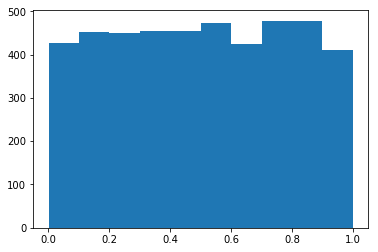

In [29]:
plt.hist(np.array(y_competencia_ejemplo))
plt.show()

## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia. 

X_dev: (400, 200), y_dev: (400, 1) para desarrollo
X_eval: (100, 200), y_eval: (100, 1) para evaluación


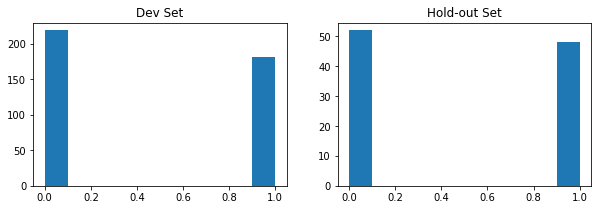

In [3]:
# EJERCICIO 1. 

np.random.seed(1234)


########################################################
## AQUI VA SU CODIGO
# X_dev, X_eval, y_dev, y_eval = X, X, y, y  # cambiar esta línea si lo consideran necesario

X_dev, X_eval, y_dev, y_eval = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
#X_dev, X_eval, y_dev, y_eval = sklearn.model_selection.train_test_split(X, y, stratify=y, test_size=0.2)

# Objetivo: variables X_dev, X_eval, y_dev e y_eval asignadas
#########################################################


print("X_dev: {}, y_dev: {} para desarrollo".format(X_dev.shape, y_dev.shape))
print("X_eval: {}, y_eval: {} para evaluación".format(X_eval.shape, y_eval.shape))

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.hist(np.array(y_dev))  # muestra un histograma para la distribución de y.
plt.title('Dev Set')
plt.subplot(1,2,2)
plt.hist(np.array(y_eval))  # muestra un histograma para la distribución de y.
plt.title('Hold-out Set')
plt.show()

Siempre los esta separando igual. Esto es porque el np.random.seed(1234) me fija el random state. Si lo comento, cambia. Cuando lo cambio, aleatoriamente me pueden quedar balanceadas distinto las poblaciones. Eso se puede prefijar con el atributo stratify del split.

In [31]:
X_eval

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
67,-1.1195,0.6030,-0.7158,-0.3789,-0.1388,0.7073,-0.7359,...,-1.0288,-0.7579,-0.7834,-0.5957,-0.7153,-1.3174,0.7091
416,1.0271,1.1688,0.5346,-1.4661,1.3467,-0.8582,0.7915,...,0.6228,1.0473,2.0603,-0.6190,1.6026,0.3663,-0.4242
350,-0.8613,1.2813,-0.5670,0.5977,-0.5429,-0.6271,-0.3877,...,0.0876,1.2859,0.2696,-0.3639,0.5137,0.5838,0.7064
358,0.2907,1.0031,-0.5272,0.8402,-1.2717,-1.1037,0.8865,...,0.8659,-1.3016,-1.5818,-1.0231,-1.5029,0.3956,-1.5723
112,1.5610,-1.4369,0.6733,0.3506,1.2520,0.1941,0.5873,...,0.2312,1.3822,-0.3384,-0.6597,1.2298,0.9270,2.1434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,-0.6085,-0.3880,0.2325,-2.7648,-0.0115,-0.3268,-0.5620,...,0.5442,1.0271,0.4207,1.2314,-0.7099,0.6231,-0.2573
181,0.5195,0.8877,0.8757,0.7548,0.7840,-1.1044,0.3763,...,0.9216,0.8132,0.4020,0.1848,-1.0342,0.8420,-0.3683
386,-0.1442,1.4870,0.4333,0.7692,0.3280,1.6126,0.5330,...,-0.1398,-0.8055,0.2608,0.3259,0.1635,0.4384,0.4438


Probar de splitear para distintos random states con el stratify y sin. 

Habria que ver que pasaria si usaran un balance distinto de datos para la competencia. O si el balance de los datos en el entrenamiento te condiciona mucho. Si los datos estan muy desbalanceados, es mas estable el auc de la curva precision recall? Igual los datos no estan casi desbalanceados. Pero si lo estuvieran, habria que ver si se le puede dar mas peso a la clase minoria, como pasa con logistic regression con el weight class. Aunque quizas splitear a ciegas es mejor para no meter proporcionalidad. Se podria ver como cambia el auc usando distintos grupos de hold out. O sea, el hold out total de 0.2 se lo puede dividir en 1 hold out de 0.1 y lo restante separarlo en 2 grupos completamente desbalanceados o en 3, agregando uno balanceado pero menor. De esa manera puedo hacer un análisis mas profundo para predecir cuanto va a dar la roc auc. Aunque el tema ahi es que pierdo tamaño del set. Y el X competencia es largo, tiene 4500 datos. Pero no sabemos si esta balanceado porque el y competencia que dieron es de ejemplo y el real lo tienen ellos.

Tambien, para predecir mejor que tan generalizable es el modelo, en lugar de separar el hold out set en varios independientes, se puede hacer bootstrapping. Manteniendo el mismo split y el mismo modelo, se pueden hacer subsets random del dev set y del holdout set y medir las aucs. Ahora no se va a tener un unico valor, si no que se va a tener una distribucion con su estadistica. Si defino que los subsets resampleados para el bootstrapping tengan el mismo stratify que el grupo total, voy a reducir la varianza producida por la estratificacion variable de los resamples. Pero quizas esto no es conveniente ya que en realidad no se si ellos van a usar una muestra igual de estratificada. Y deberia ser independiente de eso mi prediccion de cuan generalizable es el modelo.

Otra forma de ver generalizacion es repetir el proceso completo de split entrenamiento etc. Y entonces puedo sacar una estadistica, pero no voy a tener un unico modelo. Salvo que me quede con el modelo que tenga un auc igual a la mediana. Y esto esta bueno para ver como que tan distintos van a ser los modelos segun si elegi un split random especifico de casualidad u otro. Entonces puedo estudiar robustez. Y si me quedo con el modelo de la mediana, me puedo fijar la performance en train y test. Y capaz a ese modelo y split hacerle bootstrapping.

Y que pasa con las probabilidades de cada instancia? van a ser estables?

Otra cosa que se puede hacer es ver si el set de hold out tiene la misma info que el de entrenamiento. Para esto, se usa como "y" el set al que pertenece y se evalua un clasificador a ver si puede diferenciar ambos grupos. Si no puede, la info de los 2 grupos es la misma.

Para el cross validation se puede hacer kfold o one leave out, que va a ser mas costoso.

Revisar metodos de calibracion


## Ejercicio 2

### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA: Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.   **

----

,Accuracy (training),Accuracy (validación),AUC ROC (training),AUC ROC (validación)
Permutación,,,,
1,0.8150,0.5926,0.8228,0.5971
2,0.8500,0.6250,0.8516,0.6263
3,0.8063,0.6625,0.7980,0.6452
4,0.8344,0.7250,0.8285,0.7197
5,0.8037,0.5949,0.7846,0.5691


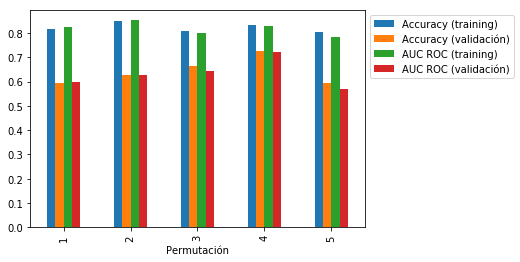

In [9]:
accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

np.random.seed(SEED) # esto lo agregue para fijar el random state

# Puede serles de utilidad tener a X_dev e y_dev como matrices de numpy directamente:
X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

########################################################
## AQUI VA SU CODIGO 
arbol_2_1 = DecisionTreeClassifier(max_depth=3)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
splits = cv.split(X_dev, y_dev)
#scores = pd.DataFrame(columns=['accuracies_training','accuracies_validation','aucs_training','aucs_validation'])
for train_idxs, val_idxs in splits:
    arbol_2_2 = DecisionTreeClassifier(max_depth=3)
    arbol_2_2.fit(X_dev.iloc[train_idxs], y_dev.iloc[train_idxs])
    y_train = y_dev.iloc[train_idxs]
    y_val = y_dev.iloc[val_idxs]
    y_train_pred = arbol_2_2.predict(X_dev.iloc[train_idxs])
    y_val_pred = arbol_2_2.predict(X_dev.iloc[val_idxs])
#    scores = scores.append(pd.Series({
#        'accuracies_training': sklearn.metrics.accuracy_score(y_train, y_train_pred),
#        'accuracies_validation': sklearn.metrics.accuracy_score(y_val, y_val_pred),
#        'aucs_training': sklearn.metrics.roc_auc_score(y_train, y_train_pred),
#        'aucs_validation': sklearn.metrics.roc_auc_score(y_val, y_val_pred)
#     }), ignore_index=True)
    accuracies_training.append(sklearn.metrics.accuracy_score(y_train, y_train_pred))
    accuracies_validation.append(sklearn.metrics.accuracy_score(y_val, y_val_pred))
    aucs_training.append(sklearn.metrics.roc_auc_score(y_train, y_train_pred))
    aucs_validation.append(sklearn.metrics.roc_auc_score(y_val, y_val_pred))
## Objetivo: accuracies_training, accuracies_validation, aucs_training y aucs_validation asignados
#########################################################

df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
                  
df["Accuracy (training)"] = accuracies_training     # cambiar por accuracies_training
df["Accuracy (validación)"] = accuracies_validation   # cambiar por accuracies_validation
df["AUC ROC (training)"] = aucs_training      # cambiar por aucs_training
df["AUC ROC (validación)"] = aucs_validation    # cambiar por aucs_validation


display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
df.plot(kind="bar")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

In [10]:
resultados_training = []
resultados_validation = []

########################################################
## AQUI VA SU CODIGO 
## Objetivo: resultados_training y resultados_validation asignadas
#
## Recomendamos seguir el siguiente esquema:
np.random.seed(SEED)
for criterio in ["gini", "entropy"]:
    for altura in [3, 5, None]:
#         CODIGO AQUI.
        arbol_2_3 = DecisionTreeClassifier(max_depth=altura, criterion=criterio)
        arbol_2_3.fit(X_dev, y_dev)    
        y_dev_pred = arbol_2_3.predict(X_dev)
        y_eval_pred = arbol_2_3.predict(X_eval)
        resultados_training.append(sklearn.metrics.roc_auc_score(y_dev, y_dev_pred))
        resultados_validation.append(sklearn.metrics.roc_auc_score(y_eval, y_eval_pred))
#########################################################

df = pd.DataFrame(index=range(0,6))

df["Altura máxima"] = [3, 5, "Inifinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC promedio (training)"] = resultados_training # reemplazar por resultados_training
df["AUC ROC promedio (validación)"] = resultados_validation # reemplazar por resultados_validation

   
display(HTML("<h3> TABLA 2 </h3>"))
display(df)

,Altura máxima,Criterio de evaluación de corte,AUC ROC promedio (training),AUC ROC promedio (validación)
0,3,Gini,0.8044,0.6715
1,5,Gini,0.9229,0.6763
2,Inifinito,Gini,1.0000,0.6579
3,3,Ganancia de Información,0.7890,0.6514
4,5,Ganancia de Información,0.9151,0.6346
5,Inifinito,Ganancia de Información,1.0000,0.6763


## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV

def top_resultados(grid, top=5):
    ## Si quieren, pueden utilizar esta función para imprimir las mejores combinaciones de su grid
    print("Top {} combinaciones".format(top))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=False).head(top))

########################################################
## AQUI VA SU CODIGO 
## Objetivo: comparar y explorar distintas combinaciones de parámetros para los algoritmos importados arriba
########################################################

Con el fin de evaluar las mejores combinaciones de hiperparámetros para cada algoritmo de aprendizaje que estudiaremos, utilizamos la técnica Grid Search. En todos los casos se aplica Cross-Validation con K=5.


### KNN

Comenzamos con el algoritmo KNN en un rango de 100 vecinos.

In [14]:
knn = KNeighborsClassifier()
n_neighbors = list(range(1, 101))
param_grid = dict(n_neighbors=n_neighbors)
grid = sklearn.model_selection.GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', iid='True')
grid.fit(X_dev.values, y_dev.values.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='True', n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

Verificamos las mejores características para este clasificador:

In [15]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.8560992824219568
{'n_neighbors': 60}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=60, p=2,
           weights='uniform')


Se encuentra entonces que la mejor performance de dicho clasificador está dada por 60 vecinos, y los parámetros metric y weights en 'minkowski' y 'uniform' (ambos valores por default), respectivamente. Resulta interesante estudiar cómo impacta su modificación en la performance del modelo.

Modificamos weight y nuevamente obtenemos los mejores parámetros:

In [16]:
knn = KNeighborsClassifier()
n_neighbors = list(range(1, 101))
weights = ['uniform', 'distance']
param_grid = dict(n_neighbors=n_neighbors, weights=weights)
grid = sklearn.model_selection.GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', iid='True')
grid.fit(X_dev.values, y_dev.values.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='True', n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [17]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.8572944680938867
{'n_neighbors': 60, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=60, p=2,
           weights='distance')


EL *best score* es muy similar al caso anterior pero esta vez el mejor estimador es ponderando los pesos con el valor de la distancia. El número de vecinos es el mismo en ambos casos.

A continuación probamos la métrica de distancia:

In [18]:
knn = KNeighborsClassifier()
n_neighbors = list(range(1, 101))
metrics= ['minkowski','euclidean', 'cityblock']
param_grid = dict(n_neighbors=n_neighbors, metric=metrics)
grid = sklearn.model_selection.GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', iid='True')
grid.fit(X_dev.values, y_dev.values.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='True', n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100], 'metric': ['minkowski', 'euclidean', 'cityblock']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [20]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.8560992824219568
{'n_neighbors': 60, 'metric': 'minkowski'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=60, p=2,
           weights='uniform')


En este caso, el *best score* sigue siendo similar al caso de buscar únicamente el número de vecinos. Incluso la mejor métrica para medir distancia es 'minkowski', es decir la de default. 

Pot último, vemos la diferencia en el tipo de búsqueda: Grid search vs Random search.

In [21]:
########### OJO: EN RANDOM PONER LA DISTRIBUCION
########### SACAR EL TIEMPO
import time
knn = KNeighborsClassifier()
n_neighbors = list(range(1, 101))
param_grid = dict(n_neighbors=n_neighbors)
grid = sklearn.model_selection.GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', iid='True')
start = time.time()
grid.fit(X_dev.values, y_dev.values.ravel())
print('grid search took {:.2f} seconds'.format(time.time() - start))
print(grid.best_params_)
rand = sklearn.model_selection.RandomizedSearchCV(knn, param_grid, cv=5, scoring='roc_auc', n_iter=20, iid='True')
start = time.time()
rand.fit(X_dev.values, y_dev.values.ravel())
print('random search took {:.2f} seconds'.format(time.time() - start))
print(rand.best_params_)

grid search took 43.59 seconds
{'n_neighbors': 60}
random search took 9.57 seconds
{'n_neighbors': 58}


Se observa entonces ................................................ 

In [22]:
#### DUDAS
    ## TABLAS
        # los resultados de cada clasificadores q enocntramos con grid.lala los podriamos poner en una tabla
        # asi se ven mejor la comparacion.
    

### Decision Tree

Utilizamos los mismos parámetros generales que en el caso anterior. Probaremos la *performance* del clasificador variando el tamaño de los árboles a través de *max_deph* y *min_sample_leaf*. Este último hiperparámetro fija el número mínimo de instancias necesarias para que se produzca una división. Estudiaremos además cómo cambia la curva ROC con los criterios *Gini* y *Entropy*.

In [7]:
max_depth = list(range(1,30))
min_samples_leaf = list(range(1,101))
criterion = ['gini', 'entropy']
param_grid = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf, criterion=criterion)
tree = sklearn.tree.DecisionTreeClassifier()
grid = sklearn.model_selection.GridSearchCV(tree, param_grid=param_grid, cv=5, scoring='roc_auc', iid='True')
grid.fit(X_dev, y_dev.values.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='True', n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, ...6, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

A continuación vemos que  el mejor estimador en este caso viene dado por profundidad máxima de 5, min_samples_leaf 30 y criterio de la información para separar nodos:

In [9]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.7743967805014316
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 30}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


Veamos que sucede estudiando un parámetro a la vez con Grid Search:

In [10]:
# solo max depth
max_depth = list(range(1,30))
criterion = ['gini', 'entropy']
param_grid = dict(max_depth=max_depth, criterion=criterion)
tree = sklearn.tree.DecisionTreeClassifier()
grid = sklearn.model_selection.GridSearchCV(tree, param_grid=param_grid, cv=5, scoring='roc_auc', iid='True')
grid.fit(X_dev, y_dev.values.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='True', n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [11]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.7079774370035998
{'criterion': 'entropy', 'max_depth': 4}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [12]:
# solo con min leaf 
min_samples_leaf = list(range(1,101))
criterion = ['gini', 'entropy']
param_grid = dict(min_samples_leaf=min_samples_leaf, criterion=criterion)
tree = sklearn.tree.DecisionTreeClassifier()
grid = sklearn.model_selection.GridSearchCV(tree, param_grid=param_grid, cv=5, scoring='roc_auc', iid='True')
grid.fit(X_dev, y_dev.values.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='True', n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       

In [13]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.7716636350938677
{'criterion': 'entropy', 'min_samples_leaf': 31}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=31, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


Comparando *best scores* vemos que con el primer caso (profundidad máxima y mínimo de samples por hoja) se obtiene un resultado semejante al 3ero, en el cual sólo se estudia la cantidad mínima de samples por hoja. Sin embargo, la altura máxima del primer caso (max_depth = 5) también es semejante respecto al segundo caso (max_depth = 4) a pesar de haber disminuido el *best_score*. En todos los casos, el criterio para una mejor clasificación fue la entropía.

### LDA

En este caso los hiperparámetros cuya combinación queres optimizar son: *n_components* y *solver*. Este último fija la técnica que aplicará el clasificador: descomposición en autovalores, cuadrados mínimos y descomposición en valores singulares (SVD - default).

In [21]:
solver = ['svd','lsqr','eigen']
n_components = list(range(0,201,20))
param_grid = dict(solver=solver, n_components=n_components)
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
grid = sklearn.model_selection.GridSearchCV(lda,param_grid=param_grid, cv=5, scoring='roc_auc', iid='True')
grid.fit(X_dev, y_dev.values.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001),
       fit_params=None, iid='True', n_jobs=1,
       param_grid={'n_components': [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200], 'solver': ['svd', 'lsqr', 'eigen']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [22]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.7349727475890266
{'n_components': 0, 'solver': 'svd'}
LinearDiscriminantAnalysis(n_components=0, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)


El mejor estimador viene dado por cero componentes y svd.

### Naive Bayes

En este caso no contamos con información de los Minions que nos permitan introducir un prior como hiperparámetro a variar.

In [28]:
#var_smoothing = np.logspace(-10, 1, 12)
#param_grid = dict(var_smoothing=var_smoothing)
nb = sklearn.naive_bayes.GaussianNB()
nb.fit(X_dev, y_dev.values.ravel())
#grid = sklearn.model_selection.GridSearchCV(nb, cv=5, scoring='roc_auc', iid='True')
#grid.fit(X_dev, y_dev.values.ravel())

GaussianNB(priors=None)

In [29]:
####### VER NB

### SVM

En este caso usaremos como hiperparámetros a C (penalidades de error) y el tipo de kernel (no con la opcion *precomputed* ya que requiere que X_dev sea una matriz cuadrada).

In [37]:
C_range = np.logspace(-2, 5, 8)
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
#gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(kernel=kernel, C=C_range)
grid = sklearn.model_selection.GridSearchCV(sklearn.svm.SVC(), param_grid=param_grid, scoring='roc_auc', cv=5, iid='True')
grid.fit(X_dev, y_dev.values.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='True', n_jobs=1,
       param_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [38]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.8639886847735686
{'kernel': 'rbf', 'C': 10.0}
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


El mejor estimador viene dado por el kernel de default (rbf) y C = 10. Veamos variando C y el rango de gamma:

In [42]:
C_range = np.logspace(-2, 5, 8)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = sklearn.model_selection.GridSearchCV(sklearn.svm.SVC(), param_grid=param_grid, scoring='roc_auc', cv=5, iid='True')
grid.fit(X_dev, y_dev.values.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='True', n_jobs=1,
       param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]), 'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [43]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.857522459034087
{'C': 10.0, 'gamma': 0.0001}
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


En este caso el *best score* esta por debajo del caso anterior con gamma = auto.

In [44]:
########## HACER:

    # TABLAS PARA FACILITAR LA VISUALIZACION DE LOS RESULTADOS
    # Q ONDA NB?
    # RANDOM SEARCH EN TODOS LOS CASOS

#### Conclusiones Grid Search

< < COMPLETAR > >

## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----




## Competencias

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


## Entrega
- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.
